In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ROOT = '/content/drive/MyDrive/AIO_Colab_Notebooks/MODULE_2/PROJECT_IMAGES_RETRIEVAL/data'

CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))
# os.listdir(): returns a list containing the names of the entries (files and directories) in the directory given by the path
# list(): is used for clarity or to ensure the result is explicitly treated as a list

In [4]:
# Image.open(path): opens the image file located at the specified path, this function returns an image object
# .convert('RGB'): method, converts the image to RGB mode
# resize(size): resizes the image to the dimensions specified by the size parameter, which is expected to be a tuple (width, height)
# np.array(im): this array will be of shape (height, width, 3) for an RGB image, where 3 represents the three color channels

def read_image_from_path(path, size):
    im = Image.open(path).convert('RGB').resize(size)
    return np.array(im)

# => This function is used to read an image from a specified file path, convert it to a standard RGB color format, resize it to a specific size,
# and then return it as a NumPy array

In [5]:
def folder_to_images(folder, size):

    list_dir = [folder + '/' + name for name in os.listdir(folder)] # creates a list of full paths to each image in the folder

    # Initializes a 4D NumPy array images_np with zeros
    # Each element of this array will eventually store the pixel data for a corresponding image in the folder.
    # This fills up the 4D array with the pixel data of each image.
    images_np = np.zeros(shape=(len(list_dir), *size, 3)) # *size is known as the "unpacking" operator in Python, to unpack the elements of a list, tuple, or other iterable into separate arguments.

    images_path = []

    for i, path in enumerate(list_dir): # return pairs containing the index and the value from the list_dir
        images_np[i] = read_image_from_path(path, size)
        images_path.append(path)

    images_path = np.array(images_path)
    return images_np, images_path

  # Remark:
    # Batch Processing: The function processes an entire batch of images at once. Instead of dealing with one image at a time,
    # it handles all images in the folder, stores them in a consistent format, and returns them as a batch in the form of a 4D NumPy array.


In [6]:
###################################### RETRIEVAL WITH L1 DISTANCE ####################################################

In [7]:
def absolute_difference(query, data):
    # range(1, len(data.shape)): this creates a range of integers from 1 to the length of the shape tuple minus one.
      # For example (10, 128, 128, 3), this would be range(1, 4), which corresponds to the axes (1, 2, 3) — these are the axes for height, width, and channels
    # tuple(range(1, len(data.shape))): Converts the range into a tuple
    axis_batch_size = tuple(range(1,len(data.shape)))

    # data - query: This subtracts the query image from each image in the data batch.
      # Broadcasting is used here, which means the query image is automatically subtracted from each image in the batch.
      # The result is a new array of the same shape as data, where each element represents the difference between corresponding pixels in data and query
    #np.sum(..., axis=axis_batch_size): Sums the absolute differences across the specified axes.
      # In this case, it sums across the height, width, and channels dimensions, reducing each image to a single value
      # that represents the total L1 difference between that image and the query image.
    return np.sum(np.abs(data - query), axis=axis_batch_size)

In [8]:
def get_l1_score(root_img_path, query_path, size):

    query = read_image_from_path(query_path, size) # read the query image, converts it to RGB, resizes and returns it as a NumPy array

    ls_path_score = [] # an empty list to store tuples of image paths and their corresponding L1 scores

    for folder in os.listdir(root_img_path): #  Iterating Through Folders in the Root Image Path

        if folder in CLASS_NAME: # This line checks if the current folder's name is in CLASS_NAME

            path = root_img_path + folder # construct the full path to the current folder by concatenating root_img_path with the folder name
            images_np, images_path = folder_to_images(path, size) # read all images in the folder path above, resizes them to size, and
            # returns 'images_np': a 4D NumPy array containing the pixel data for all images in the folder, 'images_path': a list of the full paths to each image in the folder

            rates = absolute_difference(query, images_np) # compute the L1 distance (absolute difference) between the query image and each image in images_np,
            # rates is a 1D NumPy array where each element corresponds to the L1 score between the query image and one image in the folder

            # zip(images_path, rates): combine each image path with its corresponding L1 score into a tuple
            # list(zip(images_path, rates)): convert the zip object into a list of tuples
            # ls_path_score.extend(...): add these tuples to the ls_path_score list, this list accumulates the paths and scores for all images across all valid folders
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score

In [9]:
import matplotlib.pyplot as plt

def plot_results(query_path, ls_path_score, reverse=False):
    """
    Plots the results of the image similarity search.

    Args:
        query_path (str): Path to the query image.
        ls_path_score (list): List of tuples containing image paths and their L1 scores.
        reverse (bool, optional): Whether to sort the results in descending order. Defaults to False.
    """

    # Sort the results by score
    ls_path_score.sort(key=lambda x: x[1], reverse=reverse)

    # Display the top few results
    num_results_to_display = 5  # You can change this number
    fig, axes = plt.subplots(1, num_results_to_display + 1, figsize=(20, 5))

    # Display the query image
    query_image = plt.imread(query_path)
    axes[0].imshow(query_image)
    axes[0].set_title("Query Image")
    axes[0].axis('off')

    # Display the most similar images
    for i in range(num_results_to_display):
        image_path, score = ls_path_score[i]
        image = plt.imread(image_path)
        axes[i + 1].imshow(image)
        axes[i + 1].set_title(f"Score: {score:.2f}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

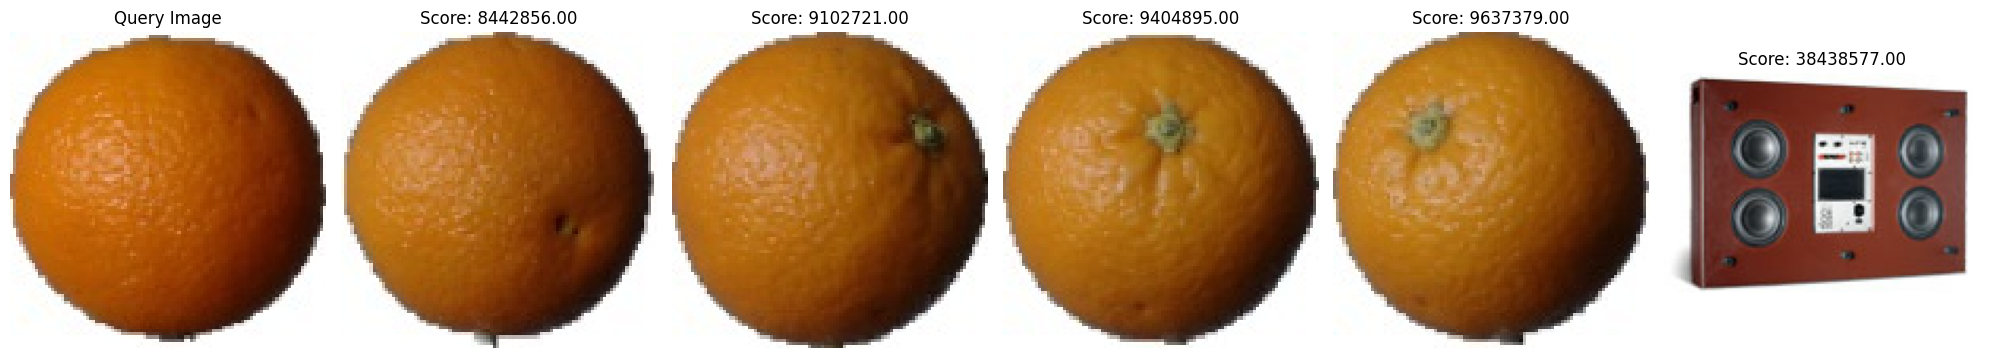

In [10]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)

plot_results(query_path, ls_path_score, reverse=False)

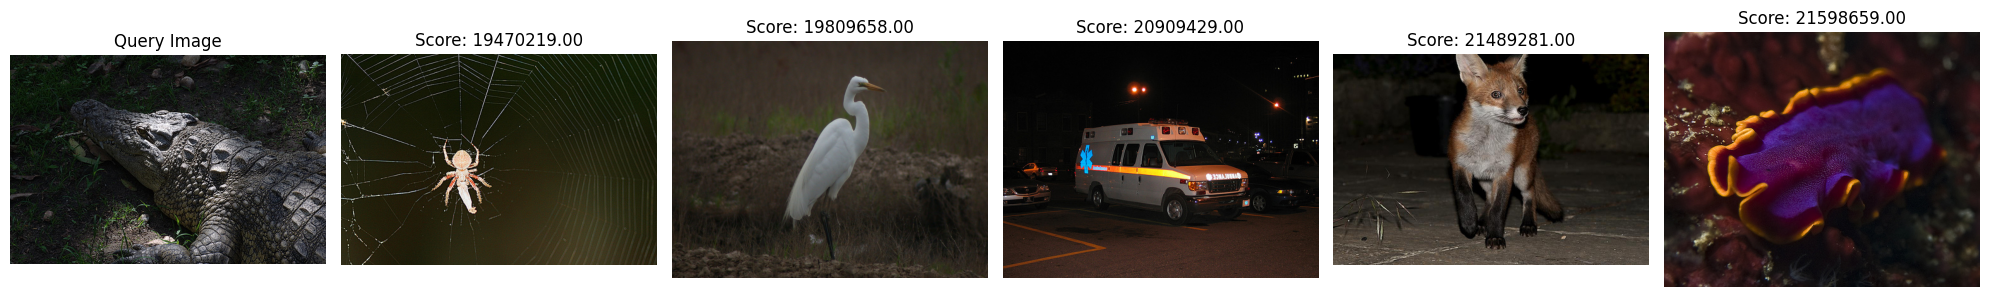

In [11]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)

plot_results(query_path, ls_path_score, reverse=False)

In [12]:
###################################### RETRIEVAL WITH L2 DISTANCE ####################################################

In [13]:
def mean_square_difference(query, data):

    axis_batch_size = tuple(range(1,len(data.shape)))

    return np.sqrt(np.sum((data - query)**2, axis=axis_batch_size))

In [14]:
def get_l2_score(root_img_path, query_path, size):

    query = read_image_from_path(query_path, size)
    ls_path_score = []

    for folder in os.listdir(root_img_path):

        if folder in CLASS_NAME:

            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size) # mang numpy nhieu anh, paths
            rates = mean_square_difference(query, images_np)
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score

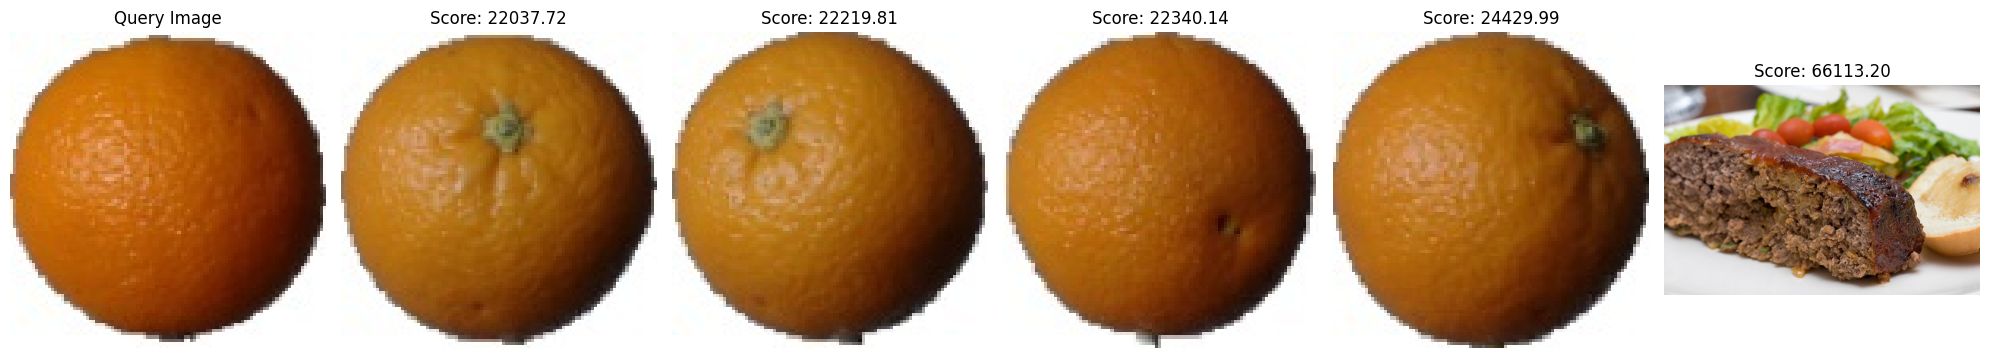

In [15]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

In [16]:
###################################### RETRIEVAL WITH COSINE SIMILARITY ####################################################
# Two identical images with different exposure levels may produce feature vectors of different lengths, but the direction of these vectors will be similar.
# Cosine similarity will detect this similarity, whereas Euclidean distance, which is affected by vector length, might not.

In [17]:
def cosine_similarity(query, data):

    axis_batch_size = tuple(range(1,len(data.shape)))

    # computes the Euclidean norm (or magnitude) of the query image
    # represents a single image (or a single feature vector), there’s no need to worry about a batch dimension so don't need to specify 'axis =...'
    # The np.sum(query**2) operation is summing over all elements of this single image (or vector) to compute its overall magnitude.
    query_norm = np.sqrt(np.sum(query**2))

    # computes the Euclidean norm (or magnitude) for each image in the batch
    # 'axis=axis_batch_size': this sums the squared values across 3 axiese H, W, C for each image
    data_norm = np.sqrt(np.sum(data**2, axis=axis_batch_size))

    return np.sum(data * query, axis=axis_batch_size) / (query_norm*data_norm + np.finfo(float).eps)

In [18]:
def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []

    for folder in os.listdir(root_img_path):
      if folder in CLASS_NAME:
        path = root_img_path + folder
        images_np, images_path = folder_to_images(path, size)

        rates = cosine_similarity(query, images_np) # broadcasting
        ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

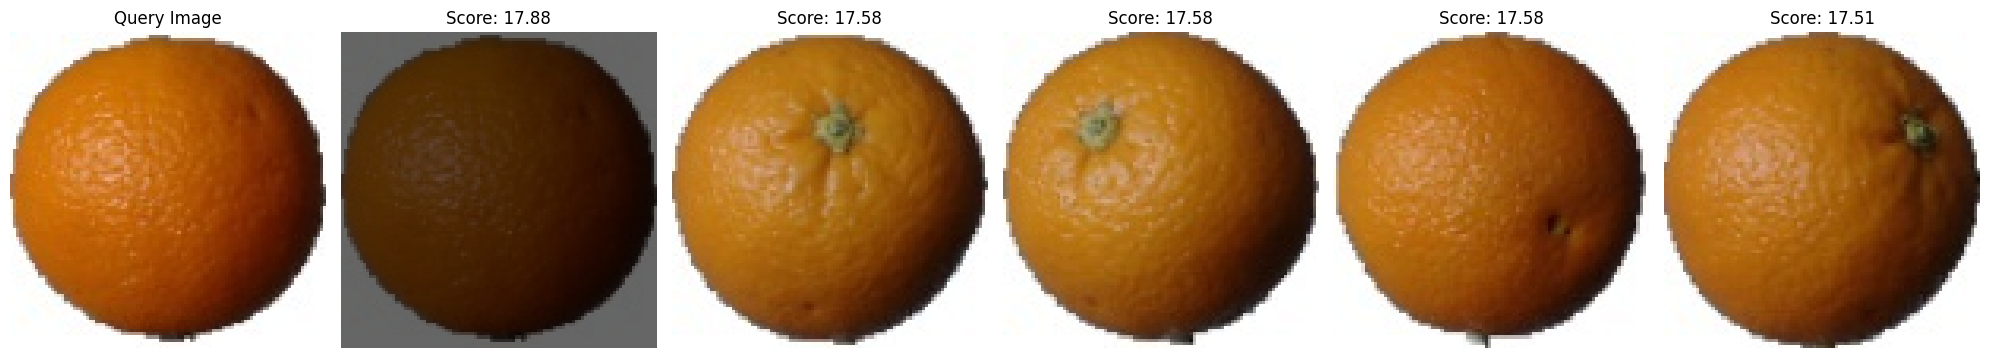

In [19]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)

plot_results(query_path, ls_path_score, reverse=True)

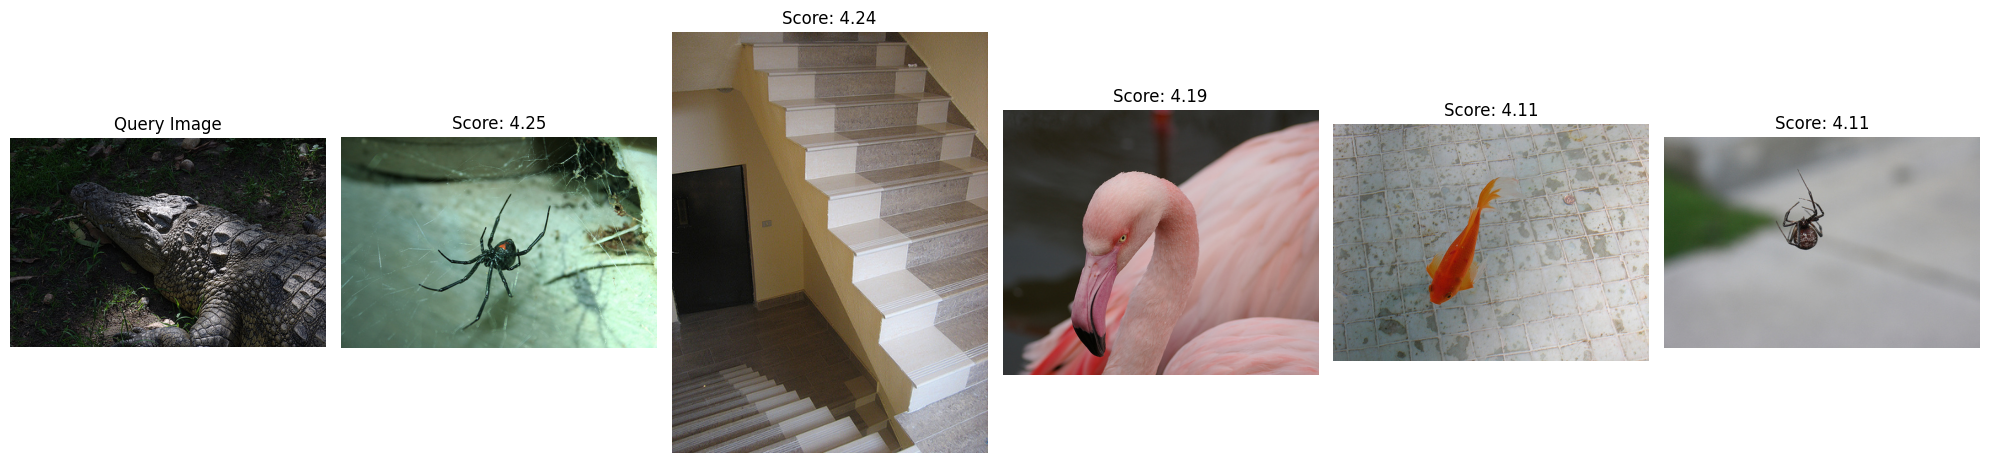

In [20]:
root_img_path =f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)

plot_results(query_path, ls_path_score, reverse=True)

In [21]:
###################################### RETRIEVAL WITH CORRELATION COEFFICIENT ####################################################

In [22]:
def correlation_coefficient(query, data):

    axis_batch_size = tuple(range(1,len(data.shape)))

    # compute the variance between query and its mean
    query_variance = query - np.mean(query) # np.mean(): compute the arithmetic mean (average) of all the elements in the array

    # compute the difference between query and its mean
    data_variance = data - np.mean(data, axis=axis_batch_size, keepdims=True) # broadcasting and then result as an array

    # compute the Euclidean norm (or magnitude) of the query image and all elements in data array
    query_variance_norm = np.sqrt(np.sum(query_variance**2))
    data_variance_norm = np.sqrt(np.sum(data_variance**2, axis=axis_batch_size))

    return np.sum(data_variance * query_variance, axis=axis_batch_size) / (query_variance_norm * data_variance_norm + np.finfo(float).eps)

In [23]:
def get_correlation_coefficient_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
      if folder in CLASS_NAME:
        path = root_img_path + folder
        images_np, images_path = folder_to_images(path, size) # mang numpy nhieu anh, paths

        rates = correlation_coefficient(query, images_np)
        ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

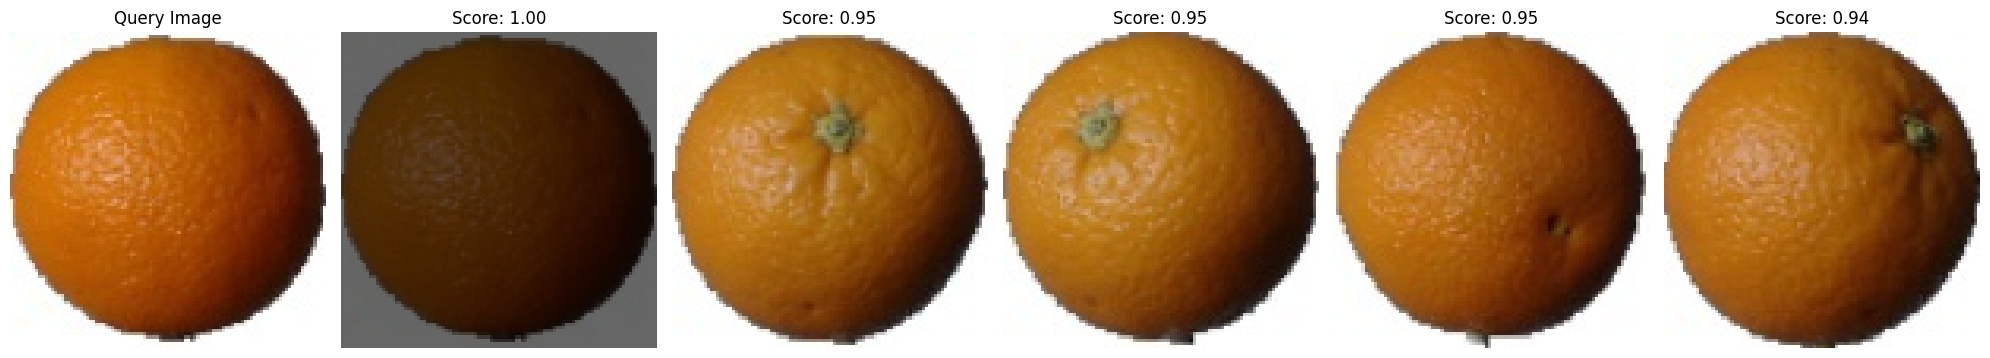

In [24]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)

plot_results(query_path, ls_path_score, reverse=True)

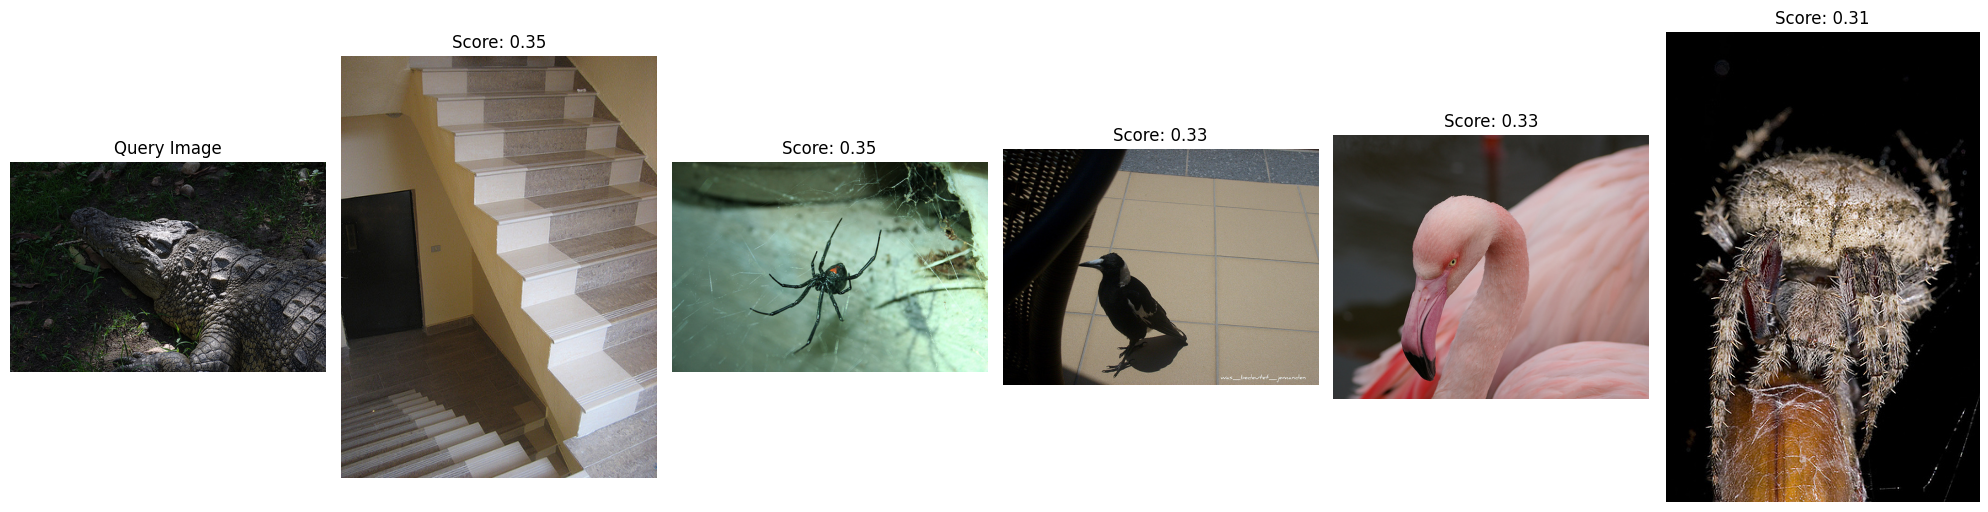

In [25]:
root_img_path =f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (448, 448)
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)

plot_results(query_path, ls_path_score, reverse=True)

In [26]:
###################################### ENHANCE IMAGES RETRIEVAL ####################################################

In [27]:
!pip install chromadb
!pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 52.3 MB/s eta 0:00:0

In [28]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [29]:
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

In [30]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=image)
    return np.array(embedding)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [31]:
################################### ENHANCE IMAGES RETRIEVAL: Query embedding vector with L1 measure ###################################

In [32]:
def get_l1_score(root_img_path, query_path, size):

    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)

    ls_path_score = []
    for folder in os.listdir(root_img_path):

        if folder in CLASS_NAME:

            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)

            embedding_list = []
            for idx_img in range(images_np.shape[0]):

                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            rates = absolute_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score

In [33]:
################################### ENHANCE IMAGES RETRIEVAL: Query embedding vector with L2 measure ###################################

In [34]:
def get_l2_score(root_img_path, query_path, size):

    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)

    ls_path_score = []
    for folder in os.listdir(root_img_path):

        if folder in CLASS_NAME:

            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)

            embedding_list = []
            for idx_img in range(images_np.shape[0]):

                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            rates = mean_square_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score

In [35]:
################################### ENHANCE IMAGES RETRIEVAL: Query embedding vector with Cosine Similarity measure ###################################

In [36]:
def get_cosine_similarity_score(root_img_path, query_path, size):

    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)

    ls_path_score = []
    for folder in os.listdir(root_img_path):

        if folder in CLASS_NAME:

            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)

            embedding_list = []
            for idx_img in range(images_np.shape[0]):

                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            rates = cosine_similarity(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score

In [37]:
################################### ENHANCE IMAGES RETRIEVAL: Query embedding vector with Correlation Coefficient measure ###################################

In [38]:
def get_correlation_coefficient_score(root_img_path, query_path, size):

    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)

    ls_path_score = []
    for folder in os.listdir(root_img_path):

        if folder in CLASS_NAME:

            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)

            embedding_list = []
            for idx_img in range(images_np.shape[0]):

                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            rates = correlation_coefficient(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))

    return query, ls_path_score

In [39]:
################################### Optimizing image retrieval using CLIP model and vector database ###################################

In [40]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)

In [51]:
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        # Open the image and read it as a NumPy array
        image = read_image_from_path(filepath)
        # Pass the NumPy array to the embedding function
        embedding = get_single_image_embedding(image=image)
        # Convert the NumPy array to a list before appending
        embeddings.append(embedding.tolist()) # Convert NumPy array to list
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

In [52]:
!pip install chromadb  # Install the chromadb library
!pip install tqdm
from tqdm import tqdm # Import the tqdm module

import chromadb  # Import the chromadb module
# Create a Chroma Client
chroma_client = chromadb.Client()
# Create a collection
# Define HNSW_SPACE if it's a constant
HNSW_SPACE = "hnsw:space"
# Create a collection
l2_collection = chroma_client.get_or_create_collection(name="l2_collection", metadata={HNSW_SPACE: "l2"})
add_embedding(collection=l2_collection, files_path=files_path)

595it [02:31,  3.92it/s]


In [86]:
def search(image_path, collection, n_results):
    # Open the image and read it as bytes
    with open(image_path, 'rb') as f:
        query_image_bytes = f.read()

    # Pass the bytes directly to the embedding function
    query_embedding = get_single_image_embedding(query_image_bytes)  # Pass bytes here

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results  # how many results to return
    )

    return results

In [89]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)
plot_results(image_path=test_path, files_path=files_path, results=l2_results)

TypeError: a bytes-like object is required, not 'JpegImageFile'

In [88]:
# Create a collection
cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection",
                                                      metadata={HNSW_SPACE: "cosine"})
add_embedding(collection=cosine_collection, files_path=files_path)

0it [00:00, ?it/s]


TypeError: get_single_image_embedding() got an unexpected keyword argument 'image'